Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
def show(costs):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.show()

In [18]:
def initialize_parameters(layers_dims):
    parameters = {}    
    for l in range(1, len(layers_dims)):
        parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([layers_dims[l-1], layers_dims[l]]))
        parameters['b' + str(l)] = tf.Variable(tf.zeros([layers_dims[l]]))
    return parameters

In [19]:
def loss_l2(beta):
    variables = tf.trainable_variables()
    lossl2 = tf.add_n([tf.nn.l2_loss(i) for i in variables]) * beta
    return lossl2

In [36]:
def model(layers = None, num_iterations = 3001, batch_size = 128, learning_rate= 0.5, 
        beta = 0.0, keep_prob = 1.0, decay_rate = 1.0, trace = True):
    costs = []
    
    graph = tf.Graph()
    with graph.as_default():

        tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size**2))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_keep_prob = tf.placeholder(tf.float32)
        
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)
        
        # learning rate decay
        global_step = tf.Variable(0, trainable=False)
        tf_learning_rate = tf.train.exponential_decay(
            learning_rate, # Base learning rate.
            global_step * batch_size, # Current index into the dataset.
            len(train_dataset), # Decay step.
            decay_rate, # Decay rate.
            staircase=True)

        if (not layers):
            layers = [ image_size**2, num_labels ]

        parameters = initialize_parameters(layers)
        
        def forward_propagation(X):
            A = X
            L = len(parameters) // 2 + 1 # number of layers in the neural network
            # linear[1] -> relu -> liner[2] -> relu -> ... -> linear[L-1]
            for l in range(1, L):
                W = parameters['W' + str(l)]
                b = parameters['b' + str(l)]
                Z = tf.add(tf.matmul(A, W), b)
                # dont apply activation on output layer
                if (l < L - 1):
                    R = tf.nn.relu(Z)
                    A = tf.nn.dropout(R, tf_keep_prob)
            return Z
        
        logits = forward_propagation(tf_train_dataset)
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))
        
        # L2 regularization
        if (beta > 0):
            loss = loss + loss_l2(beta)

        # optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        optimizer = tf.train.GradientDescentOptimizer(tf_learning_rate).minimize(loss, global_step=global_step)
        # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)        
       
        train_prediction = tf.nn.softmax(forward_propagation(tf_train_dataset))
        valid_prediction = tf.nn.softmax(forward_propagation(tf_valid_dataset))
        test_prediction = tf.nn.softmax(forward_propagation(tf_test_dataset))
    
    with tf.Session(graph=graph) as session:
    
        tf.global_variables_initializer().run()

        for step in range(num_iterations):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {
                tf_train_dataset : batch_data, 
                tf_train_labels : batch_labels,
                tf_keep_prob : keep_prob
            }
            _, step_cost, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (trace and step % 500 == 0):
                print("Minibatch loss at step %d: %f" % (step, step_cost))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                
            if (step % 5 == 0):
                costs.append(step_cost)
    
        print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval({ tf_keep_prob : 1.0}), valid_labels))
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval({ tf_keep_prob : 1.0}), test_labels))
    
    return costs

Minibatch loss at step 0: 16.460997
Minibatch accuracy: 10.2%
Minibatch loss at step 500: 2.929147
Minibatch accuracy: 65.6%
Minibatch loss at step 1000: 1.326608
Minibatch accuracy: 76.6%
Minibatch loss at step 1500: 1.342646
Minibatch accuracy: 73.4%
Minibatch loss at step 2000: 1.046066
Minibatch accuracy: 79.7%
Minibatch loss at step 2500: 1.227518
Minibatch accuracy: 73.4%
Minibatch loss at step 3000: 0.778194
Minibatch accuracy: 79.7%
Validation accuracy: 79.3%
Test accuracy: 86.3%


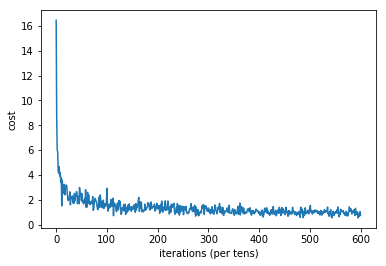

In [33]:
costs = model()
show(costs)

Minibatch loss at step 0: 22.592941
Minibatch accuracy: 5.5%
Validation accuracy: 11.1%
Test accuracy: 10.8%
Minibatch loss at step 500: 3.537610
Minibatch accuracy: 68.8%
Validation accuracy: 76.3%
Test accuracy: 83.5%
Minibatch loss at step 1000: 1.855127
Minibatch accuracy: 75.8%
Validation accuracy: 79.0%
Test accuracy: 85.7%
Minibatch loss at step 1500: 1.356031
Minibatch accuracy: 78.9%
Validation accuracy: 80.6%
Test accuracy: 87.4%
Minibatch loss at step 2000: 1.037836
Minibatch accuracy: 80.5%
Validation accuracy: 80.7%
Test accuracy: 87.8%
Minibatch loss at step 2500: 1.006117
Minibatch accuracy: 74.2%
Validation accuracy: 82.5%
Test accuracy: 88.8%
Minibatch loss at step 3000: 0.683589
Minibatch accuracy: 82.8%
Validation accuracy: 82.4%
Test accuracy: 89.2%


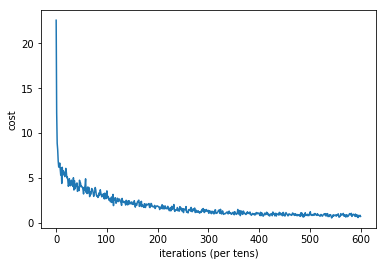

In [22]:
costs = model(beta=0.001)
show(costs)

Minibatch loss at step 0: 360.587524
Minibatch accuracy: 10.2%
Validation accuracy: 28.5%
Test accuracy: 31.2%
Minibatch loss at step 500: 18.658340
Minibatch accuracy: 70.3%
Validation accuracy: 80.3%
Test accuracy: 87.5%
Minibatch loss at step 1000: 10.476759
Minibatch accuracy: 75.8%
Validation accuracy: 80.3%
Test accuracy: 86.9%
Minibatch loss at step 1500: 12.123688
Minibatch accuracy: 77.3%
Validation accuracy: 80.9%
Test accuracy: 88.6%
Minibatch loss at step 2000: 6.362317
Minibatch accuracy: 85.2%
Validation accuracy: 81.4%
Test accuracy: 87.6%
Minibatch loss at step 2500: 9.579241
Minibatch accuracy: 80.5%
Validation accuracy: 80.1%
Test accuracy: 86.2%
Minibatch loss at step 3000: 1.671460
Minibatch accuracy: 87.5%
Validation accuracy: 83.4%
Test accuracy: 89.9%


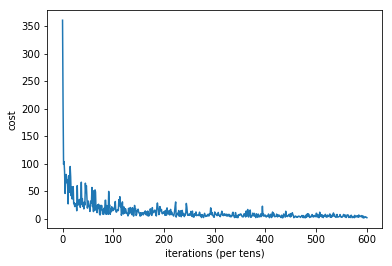

In [9]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers)
show(costs)

Minibatch loss at step 0: 900.605408
Minibatch accuracy: 14.1%
Validation accuracy: 36.2%
Test accuracy: 39.5%
Minibatch loss at step 500: 231.816116
Minibatch accuracy: 75.8%
Validation accuracy: 81.3%
Test accuracy: 88.2%
Minibatch loss at step 1000: 100.536438
Minibatch accuracy: 80.5%
Validation accuracy: 82.4%
Test accuracy: 88.9%
Minibatch loss at step 1500: 45.270012
Minibatch accuracy: 75.8%
Validation accuracy: 84.8%
Test accuracy: 91.0%
Minibatch loss at step 2000: 20.244631
Minibatch accuracy: 89.1%
Validation accuracy: 86.7%
Test accuracy: 92.7%
Minibatch loss at step 2500: 9.589923
Minibatch accuracy: 82.0%
Validation accuracy: 87.0%
Test accuracy: 92.8%
Minibatch loss at step 3000: 4.405211
Minibatch accuracy: 91.4%
Validation accuracy: 87.8%
Test accuracy: 93.4%


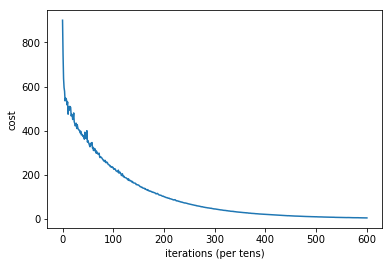

In [10]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers, beta=0.0016)
show(costs)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [11]:
train_subset = 1024
train_dataset_temp = train_dataset
train_dataset = train_dataset[:train_subset, :]
train_labels_temp = train_labels
train_labels = train_labels[:train_subset, :]

Minibatch loss at step 0: 391.370911
Minibatch accuracy: 5.5%
Validation accuracy: 30.1%
Test accuracy: 32.1%
Minibatch loss at step 500: 0.000004
Minibatch accuracy: 100.0%
Validation accuracy: 76.9%
Test accuracy: 83.7%
Minibatch loss at step 1000: 1.873972
Minibatch accuracy: 99.2%
Validation accuracy: 75.0%
Test accuracy: 81.4%
Minibatch loss at step 1500: 0.000051
Minibatch accuracy: 100.0%
Validation accuracy: 75.9%
Test accuracy: 83.1%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 77.2%
Test accuracy: 84.1%
Minibatch loss at step 2500: 0.000030
Minibatch accuracy: 100.0%
Validation accuracy: 76.8%
Test accuracy: 84.1%
Minibatch loss at step 3000: 0.000032
Minibatch accuracy: 100.0%
Validation accuracy: 76.5%
Test accuracy: 84.0%


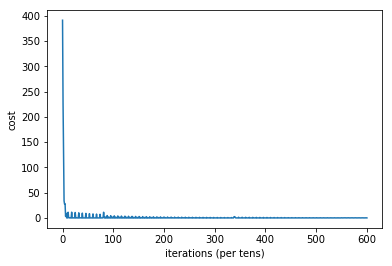

In [12]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers)
show(costs)

Minibatch loss at step 0: 518.182861
Minibatch accuracy: 12.5%
Validation accuracy: 28.1%
Test accuracy: 29.8%
Minibatch loss at step 500: 0.000000
Minibatch accuracy: 98.4%
Validation accuracy: 78.7%
Test accuracy: 85.7%
Minibatch loss at step 1000: 7.274244
Minibatch accuracy: 98.4%
Validation accuracy: 79.1%
Test accuracy: 86.1%
Minibatch loss at step 1500: 0.000000
Minibatch accuracy: 99.2%
Validation accuracy: 79.1%
Test accuracy: 86.3%
Minibatch loss at step 2000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Test accuracy: 86.3%
Minibatch loss at step 2500: 0.213548
Minibatch accuracy: 98.4%
Validation accuracy: 79.6%
Test accuracy: 86.4%
Minibatch loss at step 3000: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 79.5%
Test accuracy: 86.0%


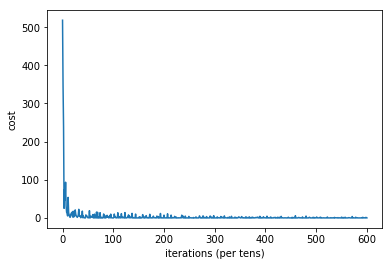

In [13]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers, keep_prob=0.5)
show(costs)

In [14]:
train_dataset = train_dataset_temp
del train_dataset_temp
train_labels = train_labels_temp
del train_labels_temp

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Minibatch loss at step 0: 998.771484
Minibatch accuracy: 9.4%
Validation accuracy: 37.3%
Test accuracy: 40.2%
Minibatch loss at step 500: 245.046677
Minibatch accuracy: 71.1%
Validation accuracy: 81.4%
Test accuracy: 87.4%
Minibatch loss at step 1000: 102.189178
Minibatch accuracy: 68.8%
Validation accuracy: 81.8%
Test accuracy: 88.4%
Minibatch loss at step 1500: 46.612961
Minibatch accuracy: 75.0%
Validation accuracy: 83.6%
Test accuracy: 89.7%
Minibatch loss at step 2000: 20.843691
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Test accuracy: 91.2%
Minibatch loss at step 2500: 9.803857
Minibatch accuracy: 82.0%
Validation accuracy: 85.9%
Test accuracy: 91.8%
Minibatch loss at step 3000: 4.485167
Minibatch accuracy: 86.7%
Validation accuracy: 86.4%
Test accuracy: 92.5%


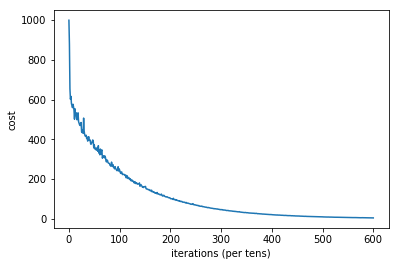

In [15]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers, beta=0.0016, keep_prob=0.5)
show(costs)

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Minibatch loss at step 0: 822.447510
Minibatch accuracy: 9.4%
Minibatch loss at step 500: 179.533051
Minibatch accuracy: 82.0%
Minibatch loss at step 1000: 71.886803
Minibatch accuracy: 82.4%
Minibatch loss at step 1500: 31.581968
Minibatch accuracy: 85.9%
Minibatch loss at step 2000: 15.389604
Minibatch accuracy: 89.8%
Minibatch loss at step 2500: 8.018182
Minibatch accuracy: 91.4%
Minibatch loss at step 3000: 4.541883
Minibatch accuracy: 92.6%
Minibatch loss at step 3500: 2.912516
Minibatch accuracy: 88.7%
Minibatch loss at step 4000: 1.885607
Minibatch accuracy: 91.8%
Minibatch loss at step 4500: 1.354897
Minibatch accuracy: 92.2%
Minibatch loss at step 5000: 1.086254
Minibatch accuracy: 88.3%
Minibatch loss at step 5500: 0.889245
Minibatch accuracy: 88.7%
Minibatch loss at step 6000: 0.768291
Minibatch accuracy: 91.0%
Minibatch loss at step 6500: 0.720140
Minibatch accuracy: 90.2%
Minibatch loss at step 7000: 0.742632
Minibatch accuracy: 86.3%
Minibatch loss at step 7500: 0.521545


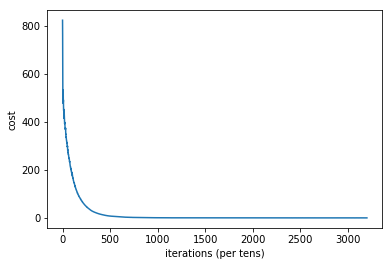

In [37]:
layers = [ image_size**2, 1024, num_labels ]
costs = model(layers, learning_rate=0.64, beta=0.0015, decay_rate=0.86, num_iterations=16001, batch_size=256)
show(costs)

Minibatch loss at step 0: 10985.183594
Minibatch accuracy: 12.5%
Validation accuracy: 34.8%
Test accuracy: 38.1%
Minibatch loss at step 500: 2263.863770
Minibatch accuracy: 75.0%
Validation accuracy: 82.8%
Test accuracy: 89.1%
Minibatch loss at step 1000: 1865.535889
Minibatch accuracy: 82.8%
Validation accuracy: 84.0%
Test accuracy: 90.0%
Minibatch loss at step 1500: 1811.707031
Minibatch accuracy: 82.8%
Validation accuracy: 84.4%
Test accuracy: 90.8%
Minibatch loss at step 2000: 1709.912720
Minibatch accuracy: 86.7%
Validation accuracy: 84.5%
Test accuracy: 90.8%
Minibatch loss at step 2500: 1734.371216
Minibatch accuracy: 84.4%
Validation accuracy: 83.5%
Test accuracy: 89.2%
Minibatch loss at step 3000: 1626.049072
Minibatch accuracy: 91.4%
Validation accuracy: 85.0%
Test accuracy: 91.0%
Minibatch loss at step 3500: 1638.218506
Minibatch accuracy: 87.5%
Validation accuracy: 85.2%
Test accuracy: 91.3%
Minibatch loss at step 4000: 1602.284424
Minibatch accuracy: 89.8%
Validation accur

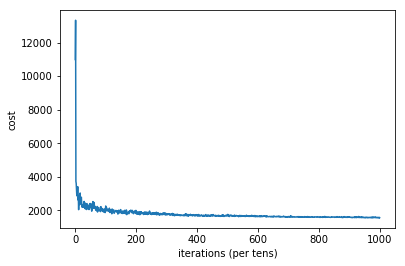

In [26]:
layers = [ image_size**2, 1024, 2048, num_labels ]
costs = model(layers, learning_rate=0.0064, beta=0.0015, keep_prob=1.0, decay_rate=0.86, batch_size=128, num_iterations=5001)
show(costs)